### BetterTogether (TM)

In [1]:
import numpy as np
from astropy.table import Table, unique
from astropy import units as u
import astropy.coordinates as coord
from astropy.time import Time
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
cutoff = int(1e6)

In [3]:
gaia_table_file = '../data/gaia-kepler-dustin.fits'
hdul = fits.open(gaia_table_file)
gaia_src_tbl = Table(hdul[1].data[:cutoff])
gaia_src_tbl = gaia_src_tbl.to_pandas()

In [4]:
pairs_file = '../data/matched-pairs-dustin.fits'
hdul = fits.open(pairs_file)
pairs = hdul[0].data[:cutoff]
#pairs = pd.DataFrame(data=pairs)

In [5]:
hdul = fits.open('../data/chisqs_matched-pairs.fits')
chisqs = hdul[0].data[:cutoff]

In [6]:
chisqs.shape

(1000000, 169)

Make a chi-squared cut & assemble the best pairs:

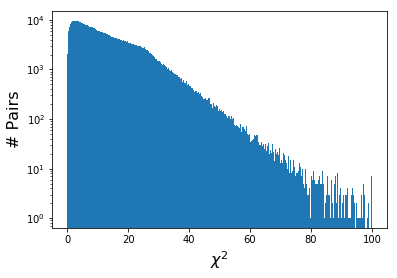

In [7]:
plt.hist(chisqs[(chisqs > 0.) & (chisqs < 100.)], bins=1000)
plt.xlabel('$\chi^2$', fontsize=16)
plt.ylabel('# Pairs', fontsize=16)
plt.yscale('log')
plt.savefig('chisq_keplerpairs.png')

In [8]:
matches_mask = (chisqs > 0) & (chisqs < 5)
np.sum(matches_mask)

426629

In [9]:
matches_mask.shape

(1000000, 169)

In [10]:
pairs.shape

(1000000, 169)

In [11]:
len_inds, len_matches = np.shape(pairs)
pairs_inds = np.array([np.arange(len_inds),]*len_matches).transpose()
pairs_ind1s = pairs_inds[matches_mask]

In [12]:
pairs_ind2s = pairs[matches_mask]
chisqs = chisqs[matches_mask]

Now let's select a random subset of 2048 pairs. We're actually going to select a larger subset and then grab only the ones where both members have significantly non-zero proper motions, to increase the likelihood that there are "true" pairs.

In [13]:
np.random.seed(42)
'''
rand_inds = np.random.randint(0, len(pairs_ind1s), 250000)
pairs_ind1s = pairs_ind1s[rand_inds]
pairs_ind2s = pairs_ind2s[rand_inds]
'''

'\nrand_inds = np.random.randint(0, len(pairs_ind1s), 250000)\npairs_ind1s = pairs_ind1s[rand_inds]\npairs_ind2s = pairs_ind2s[rand_inds]\n'

In [14]:
def make_x(star):
    """
    returns a vector of x = [parallax, pmra, pmdec]
    """
    names = ['parallax', 'pmra', 'pmdec']
    return star.loc[names].values.astype('f')

def make_xerr(star):
    """
    returns a vector of xerr = [parallax_error, pmra_error, pmdec_error]
    """
    err_names = ['parallax_error', 'pmra_error', 'pmdec_error']
    return star.loc[err_names].values.astype('f')   

def make_cov(star):
    """
    returns covariance matrix C corresponding to x
    """
    names = ['parallax', 'pmra', 'pmdec']
    C = np.diag(make_xerr(star)**2)
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if j >= i:
                continue
            corr = star.loc["{0}_{1}_corr".format(name2, name1)]
            C[i, j] = corr * np.sqrt(C[i, i] * C[j, j])
            C[j, i] = C[i, j]
    return C

In [15]:
def chisq_nonzero(star):
    """
    Chisquared-like metric to diagnose how different from zero the proper motions
    Does NOT take parallax into account
    """
    x = make_x(star)[1:]
    cov = make_cov(star)[1:,1:]
    return np.dot(x, np.linalg.solve(cov, x))

In [16]:
nonzero_mask = np.zeros_like(pairs_ind1s, dtype=bool)
for i in tqdm(range(len(nonzero_mask))):
    star1 = gaia_src_tbl.iloc[pairs_ind1s[i]]
    try:
        star2 = gaia_src_tbl.iloc[pairs_ind2s[i]]
    except: # catches error when match index isn't part of the loaded table subset
        continue
    chisq_nonzero1 = chisq_nonzero(star1)
    chisq_nonzero2 = chisq_nonzero(star2)
    if (chisq_nonzero1 >= 100) and (chisq_nonzero2 >= 100):
        if (star1['parallax'] >= 0.) and (star2['parallax'] >= 0.):
            nonzero_mask[i] = True

100%|██████████| 426629/426629 [12:33<00:00, 566.23it/s]


In [17]:
np.sum(nonzero_mask)

12466

In [18]:
pairs_ind1s = pairs_ind1s[nonzero_mask]#[:2048]
pairs_ind2s = pairs_ind2s[nonzero_mask]#[:2048]

Calculate luminosities:

In [19]:
def read_match_attr(ind1, ind2, attr):
    return gaia_src_tbl.iloc[ind1][attr].values, gaia_src_tbl.iloc[ind2][attr].values

In [20]:
(gmag1, gmag2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'phot_g_mean_mag')
(plx1, plx2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'parallax')
dist1 = 1.e3/plx1
absg1 = gmag1 - 5.*(np.log10(dist1) - 1.)
dist2 = 1.e3/plx2
absg2 = gmag2 - 5.*(np.log10(dist2) - 1.)

In [21]:
absg1

array([9.325354 , 3.5328999, 5.501754 , ..., 3.7833796, 9.105668 ,
       6.8407717], dtype=float32)

Now grab the fainter of each pair and make a CMD:

In [22]:
#pairs_2d = np.vstack([pairs_ind1s, pairs_ind2s])
#absgs_2d = np.vstack([absg1, absg2])
#argsort_absgs_2d = np.argsort(absgs_2d, axis=0)

In [23]:
# this is dumb but I can't figure out how to make the argsort method work:
pairs_indfaints = np.zeros_like(pairs_ind1s)
pairs_indbrights = np.zeros_like(pairs_ind1s)
for i in range(len(pairs_ind1s)):
    if gmag1[i] > gmag2[i]:
        pairs_indfaints[i] = pairs_ind1s[i]
        pairs_indbrights[i] = pairs_ind2s[i]
    else:
        pairs_indfaints[i] = pairs_ind2s[i]
        pairs_indbrights[i] = pairs_ind1s[i]        

In [24]:
np.savetxt('../data/bettertogetherpairs.txt', np.vstack([pairs_indfaints, pairs_indbrights]).T, 
           header='pairs_indfaints, pairs_indbrights', delimiter=',', fmt='%.0i')

In [25]:
(gmag1, gmag2) = read_match_attr(pairs_indfaints, pairs_indbrights, 'phot_g_mean_mag')
(bp_rp1, bp_rp2) = read_match_attr(pairs_indfaints, pairs_indbrights, 'bp_rp')

In [26]:
inds = ((gmag1 - gmag2) >= 2.) #& (bp_rp1 <= 1.0)

In [27]:
np.sum(inds)

3506

In [28]:
pairs_indbrights_cut = pairs_indbrights[inds]
pairs_indfaints_cut = pairs_indfaints[inds]
(gmag1, gmag2) = read_match_attr(pairs_indfaints_cut, pairs_indbrights_cut, 'phot_g_mean_mag')
(bp_rp1, bp_rp2) = read_match_attr(pairs_indfaints_cut, pairs_indbrights_cut, 'bp_rp')

In [29]:
(plx1, plx2) = read_match_attr(pairs_indfaints_cut, pairs_indbrights_cut, 'parallax')
(plx1e, plx2e) = read_match_attr(pairs_indfaints_cut, pairs_indbrights_cut, 'parallax_error')
dist1 = 1.e3/plx1
dist1a = 1.e3/(plx1 + plx1e)
tiny = 1e-6
dist1b = 1.e3/np.clip(plx1 - plx1e, tiny, np.Inf)
absg1a = gmag1 - 5.*(np.log10(dist1a) - 1.)
absg1b = gmag1 - 5.*(np.log10(dist1b) - 1.)
dist2 = 1.e3/plx2
absg2 = gmag2 - 5.*(np.log10(dist2) - 1.)

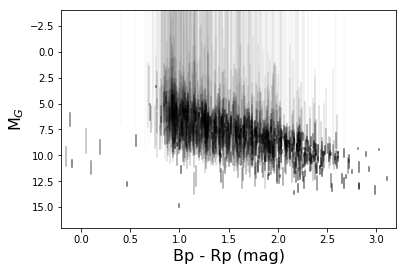

In [30]:
#plot_inds = np.random.randint(0, len(pairs_indbrights_cut), 1024)
#plot_inds = np.where(np.abs(absg1a - absg1b) < 2.0)
#plot_inds = range(len(pairs_indbrights_cut))
plot_inds = np.random.choice(np.arange(len(pairs_indbrights_cut)), 2048, replace=False)
for c, (a, b) in zip(bp_rp1[plot_inds], zip(absg1a[plot_inds], absg1b[plot_inds])):
    if np.abs(a - b) <= 1.0:
        alpha = 0.6
    else:
        alpha = 0.6/np.abs(a - b)
    plt.plot([c, c], [a, b], 'k-', alpha=alpha)
plt.ylim([17,-4])
plt.xlim([-0.2, 3.2])
plt.ylabel('M$_G$', fontsize=16)
plt.xlabel('Bp - Rp (mag)', fontsize=16)
plt.savefig('colormag_before.pdf')

Let's now combine the parallax measurements to get better constraints:

In [31]:
better_xs = []
better_covs = []
for i1, i2 in zip(pairs_indfaints_cut, pairs_indbrights_cut):
    star1 = gaia_src_tbl.iloc[i1]
    star2 = gaia_src_tbl.iloc[i2]
    cinv1 = np.linalg.inv(make_cov(star1))
    cinv2 = np.linalg.inv(make_cov(star2))
    C = np.linalg.inv(cinv1 + cinv2)
    x = np.dot(C, np.dot(cinv1, make_x(star1)) 
                      + np.dot(cinv2, make_x(star2)))
    better_xs.append(x)
    better_covs.append(C)
better_plx = np.array([x[0] for x in better_xs])
better_plx_err = np.array([np.sqrt(C[0,0]) for C in better_covs])

In [32]:
better_dist1a = 1.e3/(better_plx + better_plx_err)
tiny = 1e-6
better_dist1b = 1.e3/np.clip(better_plx - better_plx_err, tiny, np.Inf)
better_absg1a = gmag1 - 5.*(np.log10(better_dist1a) - 1.)
better_absg1b = gmag1 - 5.*(np.log10(better_dist1b) - 1.)
better_dist1 = 1.e3/better_plx
better_absg1 = gmag1 - 5.*(np.log10(better_dist1) - 1.)

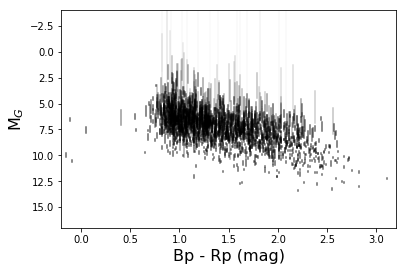

In [33]:
for c, (a, b) in zip(bp_rp1[plot_inds], zip(better_absg1a[plot_inds], better_absg1b[plot_inds])):
    if np.abs(a - b) <= 1.0:
        alpha = 0.6
    else:
        alpha = 0.6/np.abs(a - b)
    plt.plot([c, c], [a, b], 'k-', alpha=alpha)
plt.ylim([17,-4])
plt.xlim([-0.2, 3.2])
plt.ylabel('M$_G$', fontsize=16)
plt.xlabel('Bp - Rp (mag)', fontsize=16)
plt.savefig('colormag_after.pdf')

Text(0.5,0,'Bp - Rp (mag)')

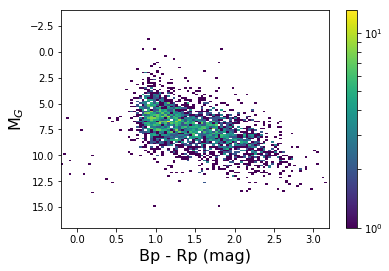

In [34]:
from matplotlib.colors import LogNorm
plt.hist2d(bp_rp1[np.isfinite(bp_rp1)], better_absg1[np.isfinite(bp_rp1)], bins=100, norm=LogNorm())
plt.colorbar()
plt.ylim([17,-4])
plt.xlim([-0.2, 3.2])
plt.ylabel('M$_G$', fontsize=16)
plt.xlabel('Bp - Rp (mag)', fontsize=16)

Plot the parallax and proper motions of a pair and then their "better together" values:

In [35]:
from plot_tools import error_ellipse
fs = 12

In [36]:
def plot_xs(i, sigma=1):
    star1 = gaia_src_tbl.iloc[pairs_indfaints_cut[i]]
    star2 = gaia_src_tbl.iloc[pairs_indbrights_cut[i]]
    x1 = make_x(star1)
    cov1 = make_cov(star1)
    x2 = make_x(star2)
    cov2 = make_cov(star2)
    better_x = better_xs[i]
    better_cov = better_covs[i]
    
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(131)
    error_ellipse(ax1, x1[0], x1[1], cov1[:2,:2], ec='red', sigma=sigma)
    error_ellipse(ax1, x2[0], x2[1], cov2[:2,:2], ec='blue', sigma=sigma)
    error_ellipse(ax1, better_x[0], better_x[1], better_cov[:2,:2], ec='green', sigma=sigma, lw=2)
    ax1.set_xlim([min([x1[0], x2[0]]) - 5., max([x1[0], x2[0]]) + 5.])
    ax1.set_ylim([min([x1[1], x2[1]]) - 5., max([x1[1], x2[1]]) + 5.])
    ax1.set_xlabel('Parallax (mas)', fontsize=fs)
    ax1.set_ylabel('PM RA (mas yr$^{-1}$)', fontsize=fs)

    ax2 = fig.add_subplot(133)
    error_ellipse(ax2, x1[1], x1[2], cov1[1:,1:], ec='red', sigma=sigma)
    error_ellipse(ax2, x2[1], x2[2], cov2[1:,1:], ec='blue', sigma=sigma)
    error_ellipse(ax2, better_x[1], better_x[2], better_cov[1:,1:], ec='green', sigma=sigma, lw=2)
    ax2.set_xlim([min([x1[1], x2[1]]) - 5., max([x1[1], x2[1]]) + 5.])
    ax2.set_ylim([min([x1[2], x2[2]]) - 5., max([x1[2], x2[2]]) + 5.])
    ax2.set_xlabel('PM RA (mas yr$^{-1}$)', fontsize=fs)
    ax2.set_ylabel('PM Dec (mas yr$^{-1}$)', fontsize=fs)
    
    ax3 = fig.add_subplot(132)
    c1 = np.delete(np.delete(cov1, 1, axis=0), 1, axis=1)
    c2 = np.delete(np.delete(cov2, 1, axis=0), 1, axis=1)
    c3 = np.delete(np.delete(better_cov, 1, axis=0), 1, axis=1)
    error_ellipse(ax3, x1[0], x1[2], c1, ec='red', sigma=sigma)
    error_ellipse(ax3, x2[0], x2[2], c2, ec='blue', sigma=sigma)
    error_ellipse(ax3, better_x[0], better_x[2], c3, ec='green', sigma=sigma, lw=2)
    ax3.set_xlim([min([x1[0], x2[0]]) - 5., max([x1[0], x2[0]]) + 5.])
    ax3.set_ylim([min([x1[2], x2[2]]) - 5., max([x1[2], x2[2]]) + 5.])
    ax3.set_xlabel('Parallax (mas)', fontsize=fs)
    ax3.set_ylabel('PM Dec (mas yr$^{-1}$)', fontsize=fs)
    
    fig.subplots_adjust(wspace = 0.5)
    fig.text(0.5, 0.95, 'match #{0}'.format(i), horizontalalignment='center', 
             transform=ax3.transAxes, fontsize=fs+2)
    fig.savefig('ellipses.pdf')

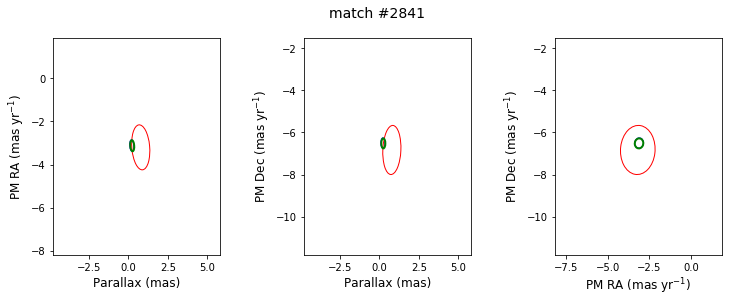

In [37]:
i = np.random.randint(0, len(pairs_indfaints_cut))
#i = 373
plot_xs(i, sigma=2)

#### Sanity checking:

Let's check that the main sequence looks ok if we just use the very best-measured stars.

In [38]:
threshold = 10 # SNR

In [39]:
np.sum(gaia_src_tbl['parallax_over_error'] > threshold)

106715

In [40]:
good_stars = gaia_src_tbl['parallax_over_error'] > threshold
gmag1 = gaia_src_tbl['phot_g_mean_mag'][good_stars]
plx1 = gaia_src_tbl['parallax'][good_stars]
plx1e = gaia_src_tbl['parallax_error'][good_stars]
bp_rp1 = gaia_src_tbl['bp_rp'][good_stars]

In [41]:
dist1 = 1.e3/plx1
dist1a = 1.e3/(plx1 + plx1e)
tiny = 1e-6
dist1b = 1.e3/np.clip(plx1 - plx1e, tiny, np.Inf)
absg1 = gmag1 - 5.*(np.log10(dist1) - 1.)
absg1a = gmag1 - 5.*(np.log10(dist1a) - 1.)
absg1b = gmag1 - 5.*(np.log10(dist1b) - 1.)

Text(0.5,0,'Bp - Rp (mag)')

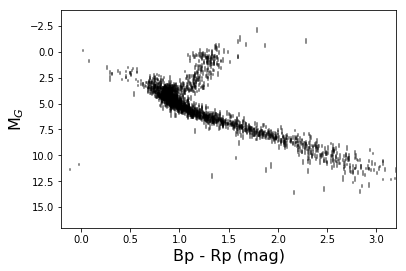

In [42]:
plot_inds2 = np.random.choice(absg1a.index, 2048, replace=False)
for c, (a, b) in zip(bp_rp1[plot_inds2], zip(absg1a[plot_inds2], absg1b[plot_inds2])):
    if np.abs(a - b) <= 1.0:
        alpha = 0.6
    else:
        alpha = 0.6/np.abs(a - b)
    plt.plot([c, c], [a, b], 'k-', alpha=alpha)
plt.ylim([17,-4])
plt.xlim([-0.2, 3.2])
plt.ylabel('M$_G$', fontsize=16)
plt.xlabel('Bp - Rp (mag)', fontsize=16)